# Obrada prirodnog jezika za razumijevanje povratnih informacija klijenata u ugostiteljskoj industriji

## Potrebni moduli

In [1]:
import re
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Učitavanje podataka

In [ ]:
# Za prikazivanje cijelih komentara
pd.set_option("max_colwidth", 100)

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/dsabljic/UUI-NLP-u-ugostiteljstvu/master/data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,"nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took adv...",4
1,"ok nothing special charge diamond member hilton decided chain shot 20th anniversary seattle, sta...",2
2,nice rooms not 4* experience hotel monaco seattle good hotel n't 4* level.positives large bathro...,3
3,"unique, great stay, wonderful time hotel monaco, location excellent short stroll main downtown s...",5
4,"great stay great stay, went seahawk game awesome, downfall view building did n't complain, room ...",5


## EDA

In [ ]:
# Vrijednosti koje nedostaju
df.isna().sum()

Review    0
Rating    0
dtype: int64

In [ ]:
df.Rating.describe()

count    20491.000000
mean         3.952223
std          1.233030
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64

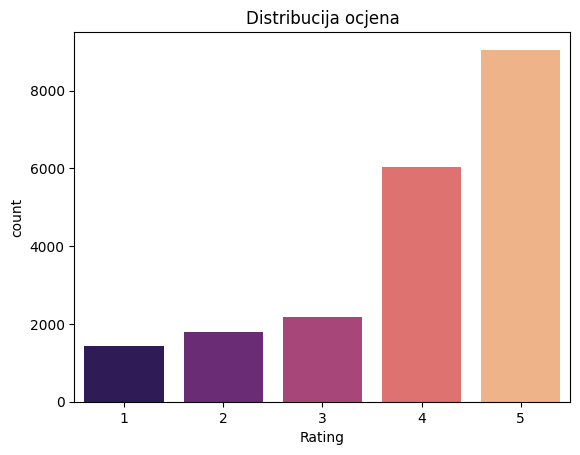

In [ ]:
# Distribucija ocjena
sns.countplot(data=df, x="Rating", palette="magma").set_title("Distribucija ocjena");

In [ ]:
# Duljina review-a (char)
df['Length'] = df['Review'].str.len()
df.head()

,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


In [ ]:
# Duljina review-a (riječ)
def word_count(review):
    review_list = review.split()
    return len(review_list)

df['Word count'] = df['Review'].apply(word_count)
df.head()

,Review,Rating,Length,Word count
0,nice hotel expensive parking got good deal sta...,4,593,87
1,ok nothing special charge diamond member hilto...,2,1689,250
2,nice rooms not 4* experience hotel monaco seat...,3,1427,217
3,"unique, great stay, wonderful time hotel monac...",5,600,89
4,"great stay great stay, went seahawk game aweso...",5,1281,191


In [ ]:
# Deskriptivna statistika
df.Length.describe()

count    20491.000000
mean       724.896833
std        689.101024
min         44.000000
25%        339.000000
50%        537.000000
75%        859.000000
max      13501.000000
Name: Length, dtype: float64

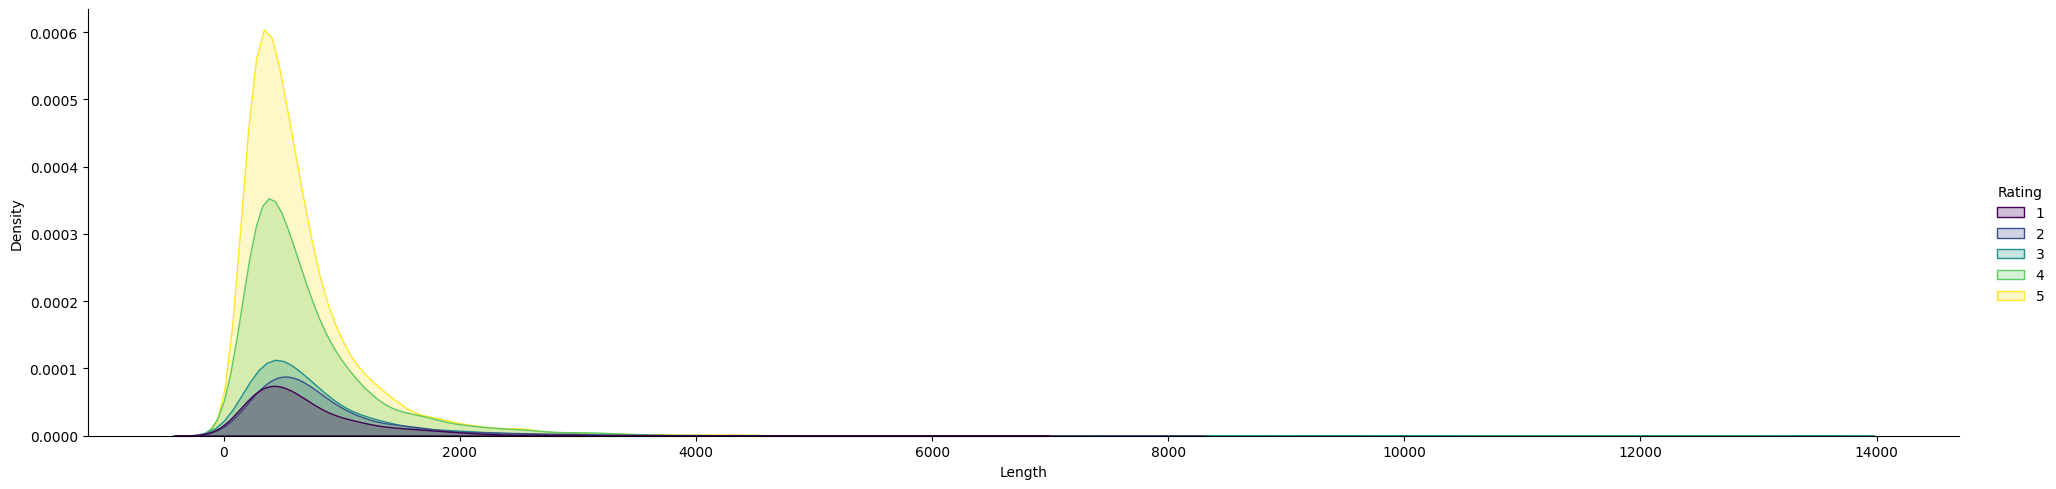

In [ ]:
sns.displot(data=df, x="Length", hue="Rating", palette="viridis", kind="kde", fill=True, aspect=4);

In [ ]:
df['Word count'].describe()

count    20491.000000
mean       104.375824
std        100.656586
min          7.000000
25%         48.000000
50%         77.000000
75%        124.000000
max       1931.000000
Name: Word count, dtype: float64

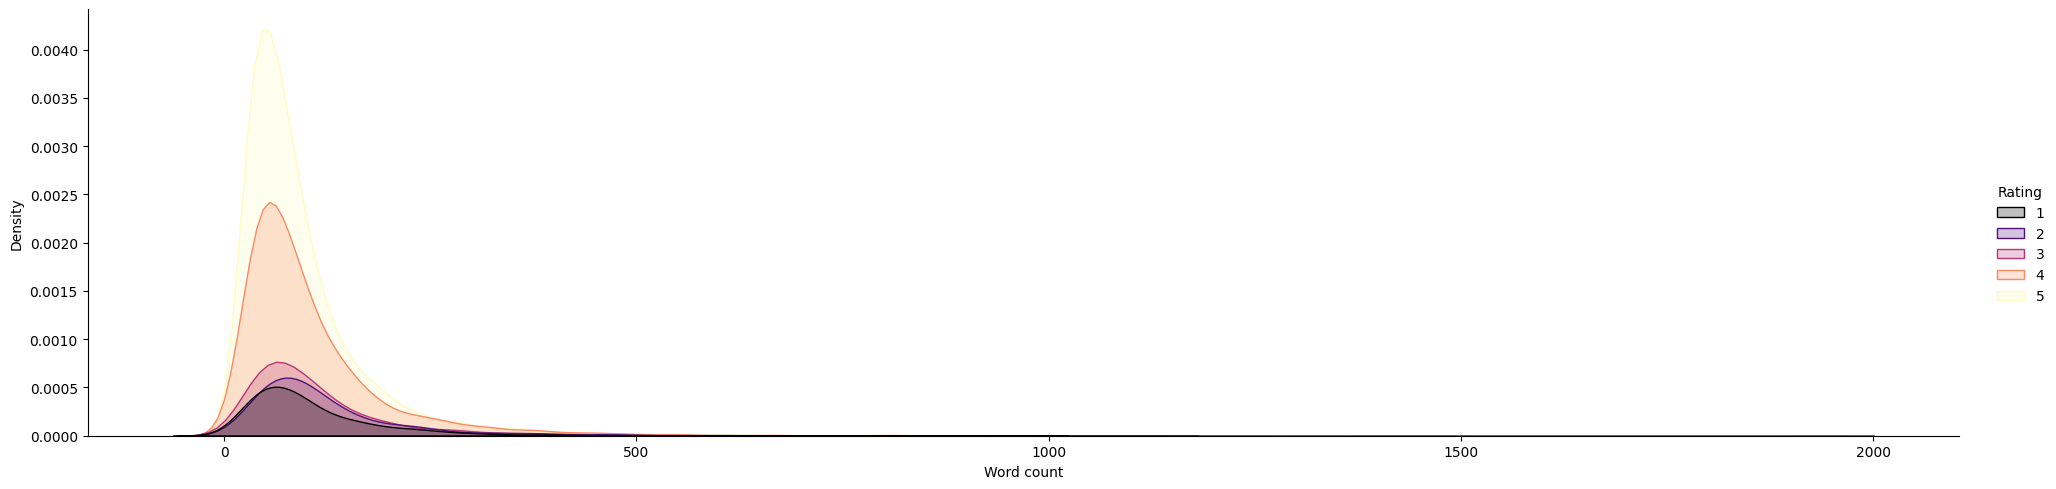

In [ ]:
sns.displot(data=df, x="Word count", hue="Rating", palette="magma", kind="kde", fill=True, aspect=4);

## Najzastupljenije riječi i *n*-grami

In [ ]:
df.drop(['Length', 'Word count'], axis = 1, inplace = True)
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [ ]:
def clean(review):

    review = review.lower()
    review = re.sub('[^a-z A-Z 0-9-]+', '', review) # uklanjanje specijalnih znakova
    review = " ".join([word for word in review.split() if word not in stopwords.words('english')])

    return review

In [ ]:
df['Review'] = df['Review'].apply(clean)

In [ ]:
def split_into_words(text):
    text_list = text.split()
    return text_list

df['Review_lists'] = df['Review'].apply(split_into_words)

In [ ]:
df.head()

,Review,Rating,Review_lists
0,nice hotel expensive parking got good deal sta...,4,"[nice, hotel, expensive, parking, got, good, d..."
1,ok nothing special charge diamond member hilto...,2,"[ok, nothing, special, charge, diamond, member..."
2,nice rooms 4 experience hotel monaco seattle g...,3,"[nice, rooms, 4, experience, hotel, monaco, se..."
3,unique great stay wonderful time hotel monaco ...,5,"[unique, great, stay, wonderful, time, hotel, ..."
4,great stay great stay went seahawk game awesom...,5,"[great, stay, great, stay, went, seahawk, game..."


In [ ]:
corpus = [word for review_list in df['Review_lists'] for word in review_list]
len(corpus)

2060911

In [ ]:
most_common_words = Counter(corpus).most_common(10)
most_common_words

[('hotel', 48844),
 ('room', 34279),
 ('great', 21068),
 ('nt', 18989),
 ('good', 16953),
 ('staff', 16193),
 ('stay', 15142),
 ('nice', 12393),
 ('rooms', 12005),
 ('location', 11009)]

In [ ]:
words, freq = zip(*most_common_words)

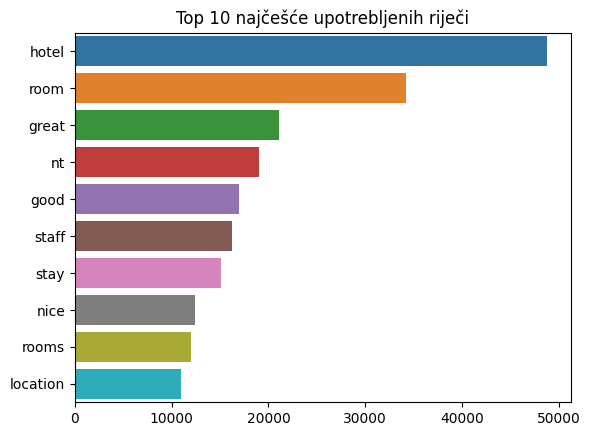

In [ ]:
sns.barplot(x=list(freq), y=list(words))
plt.title('Top 10 najčešće upotrebljenih riječi')
plt.show()

In [ ]:
def display_ngram(n, df):
  cv = CountVectorizer(ngram_range=(n,n))
  n_gram = cv.fit_transform(df['Review'])
  count_values = n_gram.toarray().sum(axis=0)
  ngram_df = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
  ngram_df.columns = ["frequency", "ngram"]

  sns.barplot(x=ngram_df['frequency'][:10], y=ngram_df['ngram'][:10])
  plt.title('Top 10 najčešćih n-grama')
  plt.show()

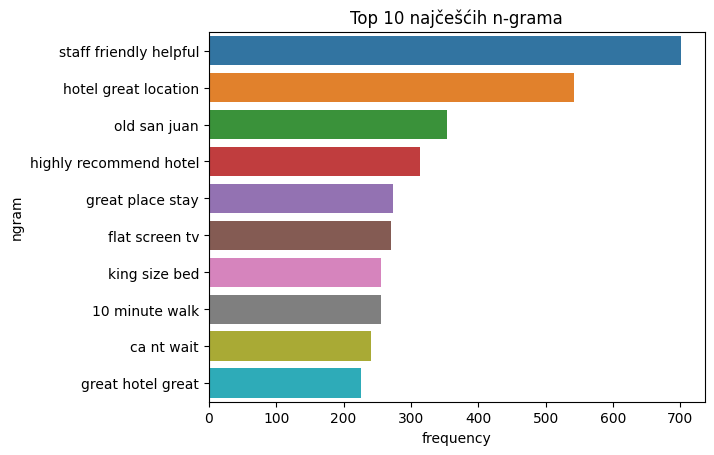

In [ ]:
n_gram = display_ngram(3, df)

## Analiza sentimenta sa sekvencijalnim modelima

// TODO
- ~~remove punctuation~~
- ~~GRU~~
- pre-trained embeddings
- BERT/RoBERTa

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, Dense, Dropout, TextVectorization
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from nltk.stem.snowball import SnowballStemmer

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/dsabljic/UUI-NLP-u-ugostiteljstvu/master/data/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
df['Label'] = df['Rating'].apply(lambda x: 0 if x in [1, 2] else (1 if x == 3 else 2))

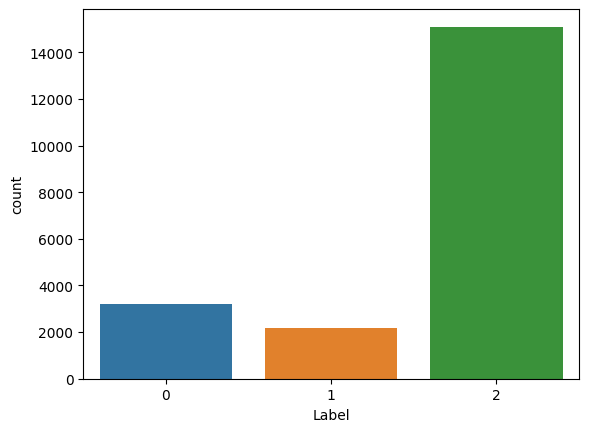

In [6]:
sns.countplot(x='Label', data=df);

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df["Review"], df["Label"], test_size=0.2, random_state=39)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=39)

In [8]:
# Definirajte stopwords i izuzmite one koji utječu na sentiment
stop_words = set(stopwords.words('english'))
words_to_keep = {'not', 'no', 'nt', 'very', 'really'}
filtered_stop_words = stop_words - words_to_keep

stemmer = SnowballStemmer("english")

def custom_preprocessing_sw_removal(text):
    # Uklanjanje interpunkcije
    text = re.sub(r'[^\w\s]', '', text)
    # Stemming i uklanjanje stopwordsa osim onih koji utječu na sentiment
    text = " ".join(stemmer.stem(word) for word in text.split() if word not in filtered_stop_words)

    return text

In [9]:
X_train = X_train.apply(custom_preprocessing_sw_removal)
X_val = X_val.apply(custom_preprocessing_sw_removal)
X_test = X_test.apply(custom_preprocessing_sw_removal)

In [10]:
batch_size = 32
VOCAB_TOKENS = 5000

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_TOKENS)

encoder.adapt(train_ds.map(lambda text, labels: text))

np.array(encoder.get_vocabulary())[:20]

array(['', '[UNK]', 'hotel', 'room', 'not', 'stay', 'great', 'nt', 'good',
       'staff', 'night', 'locat', 'nice', 'time', 'day', 'no', 'servic',
       'clean', 'walk', 'restaur'], dtype='<U14')

In [11]:
def plot_metrics(history):
    metrics = pd.DataFrame(history.history)
    metrics[['accuracy', 'val_accuracy']].plot()
    metrics[['loss', 'val_loss']].plot()

### *Vanilla* RNN

Epoch 1/10
385/385 [==============================] - 75s 188ms/step - loss: 0.8159 - accuracy: 0.7185 - val_loss: 0.7363 - val_accuracy: 0.7465
Epoch 2/10
385/385 [==============================] - 72s 186ms/step - loss: 0.7500 - accuracy: 0.7367 - val_loss: 0.6408 - val_accuracy: 0.7877
Epoch 3/10
385/385 [==============================] - 76s 196ms/step - loss: 0.5957 - accuracy: 0.7940 - val_loss: 0.5184 - val_accuracy: 0.8128
Epoch 4/10
385/385 [==============================] - 77s 200ms/step - loss: 0.5000 - accuracy: 0.8288 - val_loss: 0.4623 - val_accuracy: 0.8463
Epoch 5/10
385/385 [==============================] - 72s 188ms/step - loss: 0.4315 - accuracy: 0.8463 - val_loss: 0.4392 - val_accuracy: 0.8429
Epoch 6/10
385/385 [==============================] - 73s 189ms/step - loss: 0.3889 - accuracy: 0.8599 - val_loss: 0.4323 - val_accuracy: 0.8407
Epoch 7/10
385/385 [==============================] - 77s 201ms/step - loss: 0.3546 - accuracy: 0.8683 - val_loss: 0.4260 - val_ac

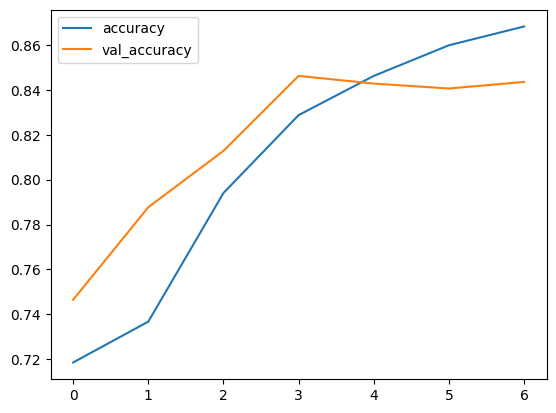

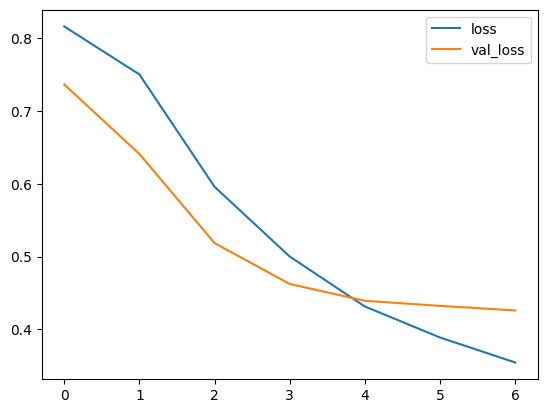

In [21]:
rnn_model39 = tf.keras.models.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 50, mask_zero = True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')])

rnn_model39.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = rnn_model39.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [22]:
test_loss, test_acc = rnn_model39.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 6s 48ms/step - loss: 0.4673 - accuracy: 0.8287
Test Loss: 0.4673411250114441
Test Accuracy: 0.8287386894226074


### GRU

Epoch 1/10
385/385 [==============================] - 68s 164ms/step - loss: 0.9982 - accuracy: 0.7353 - val_loss: 0.5873 - val_accuracy: 0.8299
Epoch 2/10
385/385 [==============================] - 34s 90ms/step - loss: 0.5538 - accuracy: 0.8332 - val_loss: 0.5243 - val_accuracy: 0.8326
Epoch 3/10
385/385 [==============================] - 24s 62ms/step - loss: 0.4742 - accuracy: 0.8536 - val_loss: 0.5182 - val_accuracy: 0.8404
Epoch 4/10
385/385 [==============================] - 18s 47ms/step - loss: 0.4334 - accuracy: 0.8638 - val_loss: 0.5048 - val_accuracy: 0.8350
Epoch 5/10
385/385 [==============================] - 14s 36ms/step - loss: 0.3922 - accuracy: 0.8735 - val_loss: 0.5143 - val_accuracy: 0.8399
Epoch 6/10
385/385 [==============================] - 17s 43ms/step - loss: 0.3666 - accuracy: 0.8804 - val_loss: 0.5197 - val_accuracy: 0.8404

Final val_accuracy: 84.04%



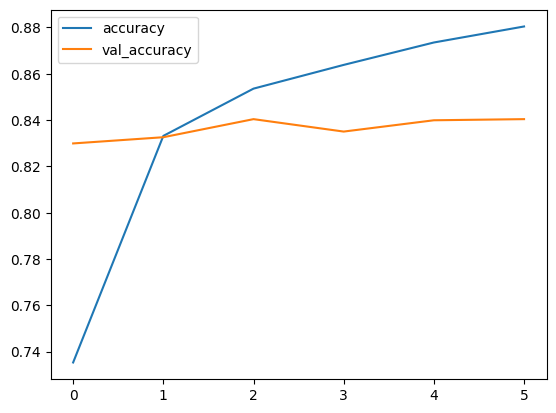

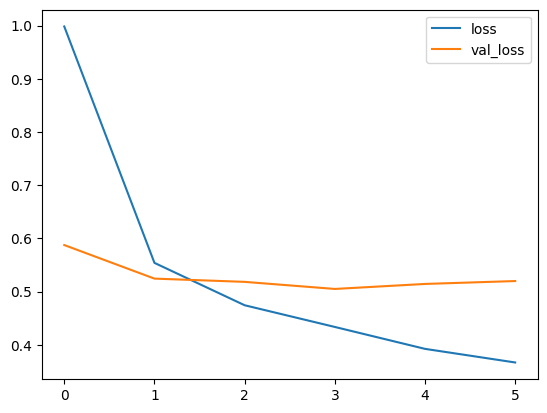

In [15]:
l1_reg = tf.keras.regularizers.l1(0.005)

gru_model39_v3 = tf.keras.models.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 100, mask_zero = True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l1_reg),
    tf.keras.layers.Dense(3, activation='softmax', kernel_regularizer=l1_reg)])

gru_model39_v3.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = gru_model39_v3.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [16]:
test_loss, test_acc = gru_model39_v3.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 3s 20ms/step - loss: 0.5402 - accuracy: 0.8273
Test Loss: 0.5401970148086548
Test Accuracy: 0.8272749185562134


## GloVe

In [17]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2024-01-09 18:04:35--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-01-09 18:04:35--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 38s  

2024-01-09 18:07:14 (5.19 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [18]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [19]:
glove_path = './glove.6B.100d.txt'

embeddings_index = {}
with open(glove_path, 'r', encoding='utf8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

In [20]:
vocab = encoder.get_vocabulary()
embedding_dim = 100
embedding_matrix = np.zeros((len(vocab), embedding_dim))

for i, word in enumerate(vocab):
    if word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim, ))

embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(vocab),
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    trainable=False
)

Epoch 1/20
385/385 [==============================] - 19s 37ms/step - loss: 0.5985 - accuracy: 0.7709 - val_loss: 0.4691 - val_accuracy: 0.8238
Epoch 2/20
385/385 [==============================] - 13s 34ms/step - loss: 0.4604 - accuracy: 0.8264 - val_loss: 0.4172 - val_accuracy: 0.8421
Epoch 3/20
385/385 [==============================] - 13s 33ms/step - loss: 0.4057 - accuracy: 0.8481 - val_loss: 0.3971 - val_accuracy: 0.8514
Epoch 4/20
385/385 [==============================] - 13s 33ms/step - loss: 0.3742 - accuracy: 0.8557 - val_loss: 0.3812 - val_accuracy: 0.8568
Epoch 5/20
385/385 [==============================] - 13s 32ms/step - loss: 0.3495 - accuracy: 0.8643 - val_loss: 0.3967 - val_accuracy: 0.8441
Epoch 6/20
385/385 [==============================] - 13s 33ms/step - loss: 0.3292 - accuracy: 0.8738 - val_loss: 0.3914 - val_accuracy: 0.8492

Final val_accuracy: 84.92%



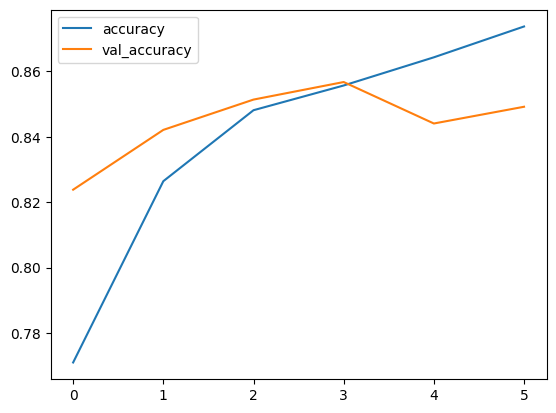

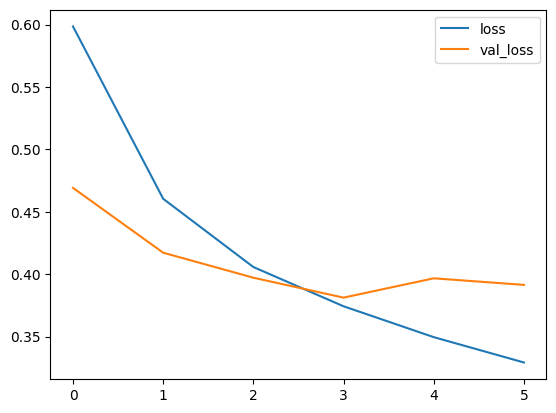

In [21]:
gru_model_glove = tf.keras.models.Sequential([
    encoder,
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')])

gru_model_glove.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = gru_model_glove.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_accuracy")])
print(f"\nFinal val_accuracy: {history.history['val_accuracy'][-1]:.2%}\n")

plot_metrics(history)

In [22]:
test_loss, test_acc = gru_model_glove.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

129/129 [==============================] - 2s 15ms/step - loss: 0.3747 - accuracy: 0.8600
Test Loss: 0.3746583163738251
Test Accuracy: 0.8599658608436584
